In [24]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [25]:
# Get project files

!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'
train_dir = os.path.join(os.getcwd(),  'cats_and_dogs/train')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 64
epochs = 23
IMG_HEIGHT = 215
IMG_WIDTH = 215

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [26]:
# ImageDataGenerator with rescaling
train_image_generator = ImageDataGenerator(rescale=1.0/255.0)
validation_image_generator = ImageDataGenerator(rescale=1.0/255.0)
test_image_generator = ImageDataGenerator(rescale=1.0/255.0)

# Generate data from directories
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    batch_size=batch_size,
    directory=validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Create a subdirectory for the test images if it doesn't exist
test_images_dir = os.path.join(test_dir, 'test_images')
if not os.path.exists(test_images_dir):
    os.makedirs(test_images_dir)
    for file_name in os.listdir(test_dir):
        # Move only the images, ignore directories like 'test_images' if it already exists
        if os.path.isfile(os.path.join(test_dir, file_name)):
            os.rename(os.path.join(test_dir, file_name), os.path.join(test_images_dir, file_name))

# Use flow_from_directory pointing to the new subdirectory
test_data_gen = test_image_generator.flow_from_directory(
    directory=test_dir,  # Now pointing to the 'test' folder which contains 'test_images'
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode=None,  # No labels required
    shuffle=False
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


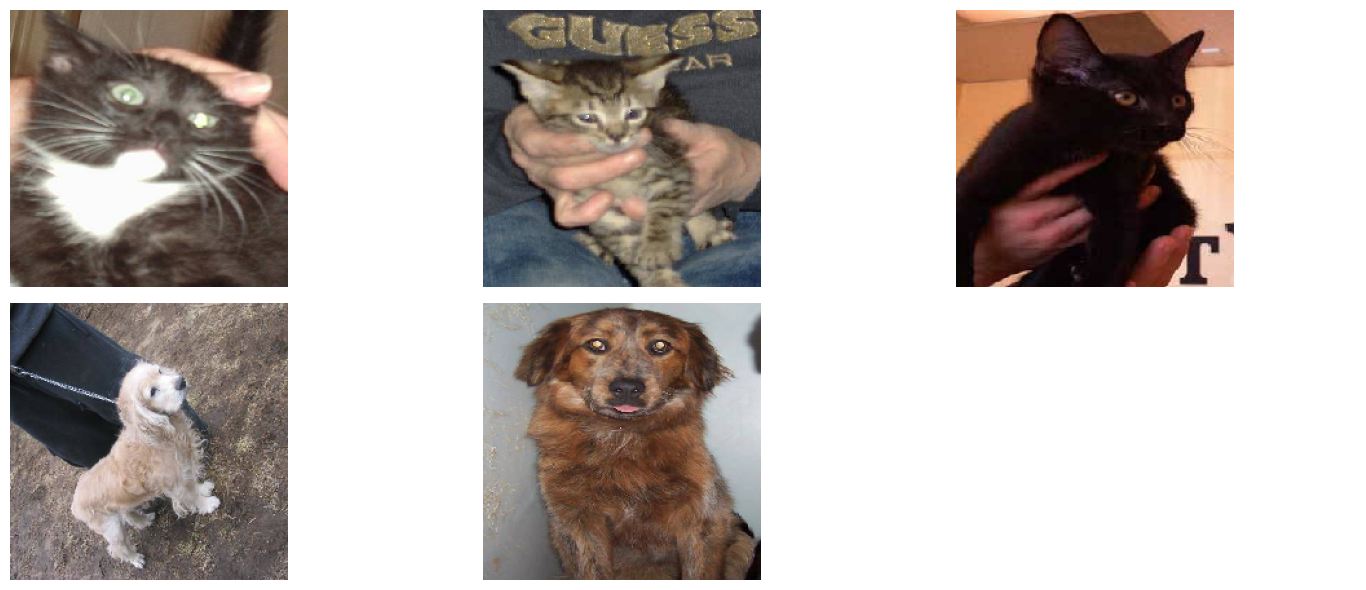

In [27]:
# 4
def plotImages(images_arr, probabilities=False, titles=None, num_cols=2, cmap=None):
    """
    Plots a grid of images with optional probabilities and titles.

    Args:
        images_arr (list or numpy array): Array of images to display.
        probabilities (list, optional): Array of probabilities for each image. Defaults to False.
        titles (list, optional): Array of custom titles for each image. Defaults to None.
        num_cols (int, optional): Number of columns in the grid. Defaults to 2.
        cmap (str, optional): Colormap to apply to images (e.g., 'gray'). Defaults to None.

    Raises:
        ValueError: If the length of images_arr and probabilities/titles do not match.
    """

    # Check for matching lengths if probabilities or titles are provided
    if probabilities is not False and len(images_arr) != len(probabilities):
        raise ValueError("Number of images and probabilities must match!")

    if titles and len(images_arr) != len(titles):
        raise ValueError("Number of images and titles must match!")

    # Calculate number of rows needed
    num_rows = (len(images_arr) + num_cols - 1) // num_cols

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate over images and corresponding axes
    for i, (img, ax) in enumerate(zip(images_arr, axes)):
        ax.imshow(img, cmap=cmap)  # Apply colormap if provided
        ax.axis('off')  # Turn off axis numbers and ticks

        # Set titles based on probabilities or custom titles
        if probabilities is not False:
            probability = probabilities[i]
            if probability > 0.5:
                ax.set_title(f"{probability * 100:.2f}% dog")
            else:
                ax.set_title(f"{(1 - probability) * 100:.2f}% cat")
        elif titles:
            ax.set_title(titles[i])

    # Hide any unused subplots
    for ax in axes[len(images_arr):]:
        ax.axis('off')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Example usage with model predictions
def plotImagesWithModel(images_arr, model=None, num_cols=2, cmap=None):
    """
    Plots images with predictions from a model.

    Args:
        images_arr (list or numpy array): Array of images to display.
        model (keras.Model, optional): A trained model to generate predictions. Defaults to None.
        num_cols (int, optional): Number of columns in the grid. Defaults to 2.
        cmap (str, optional): Colormap to apply to images (e.g., 'gray'). Defaults to None.
    """
    if model:
        probabilities = model.predict(images_arr)
        probabilities = probabilities.flatten()  # Ensure probabilities are 1D
        plotImages(images_arr, probabilities=probabilities, num_cols=num_cols, cmap=cmap)
    else:
        plotImages(images_arr, num_cols=num_cols, cmap=cmap)

# Sample usage
sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5], num_cols=3, cmap='gray')



In [28]:
# 5
train_image_generator = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values to [0, 1]
    rotation_range=40,  # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,  # Randomly apply shearing transformations
    zoom_range=0.2,  # Randomly zoom in/out on images
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically (added for more variety)
    fill_mode='reflect',  # Reflect edge pixels to fill in newly created pixels after transformations
    brightness_range=[0.8, 1.2],  # Randomly change the brightness of images
    channel_shift_range=0.1,  # Randomly shift the RGB channels (colors)
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input  # Preprocess according to VGG16 (if using a specific pre-trained model)
)


Found 2000 images belonging to 2 classes.


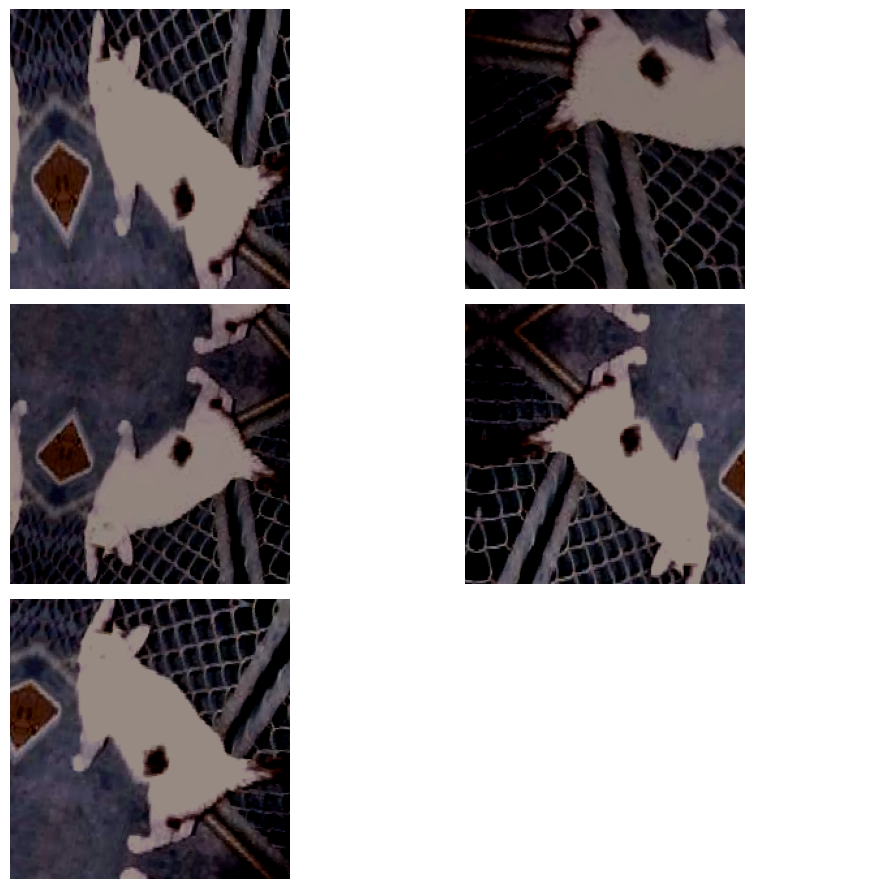

In [29]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     shuffle=True,
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Constants
IMG_HEIGHT = 215
IMG_WIDTH = 215
IMG_CHANNELS = 3

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    GlobalAveragePooling2D(),

    Dense(1024, activation='relu'),
    Dropout(0.5),

    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Check the model summary to inspect the shapes
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 213, 213, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 106, 106, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 104, 104, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 52, 52, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 23, 23, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 11, 11, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 9, 9, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,094,913 (7.99 MB)

 Trainable params: 2,094,913 (7.99 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# 8
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Constants
epochs = 22
batch_size = 32
IMG_HEIGHT = 215
IMG_WIDTH = 215

# Calculate the number of steps per epoch
steps_per_epoch = total_train // batch_size
validation_steps =total_val // batch_size

# Early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=6,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the model weights from the epoch with the best value of the monitored quantity
)

# Learning rate scheduler to adjust learning rate during training
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce the learning rate by a factor of 0.5
    patience=3,  # Wait for 3 epochs before reducing the learning rate
    min_lr=0.00001  # Minimum learning rate
)

# Model checkpoint to save the best model during training
checkpoint = ModelCheckpoint(
    'best_model.keras',  # Filepath to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    verbose=1  # Print messages when the model is saved
)

# TensorBoard for visualizing training metrics
tensorboard = TensorBoard(
    log_dir='logs',  # Directory where logs are saved
    histogram_freq=1,  # Frequency of computing histograms
    write_graph=True,  # Whether to visualize the graph
    write_images=True  # Whether to write model weights as images
)

# Train the model
history = model.fit(
    x=train_data_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping_callback, lr_scheduler, checkpoint, tensorboard]
)

Epoch 1/22
32/62 ━━━━━━━━━━━━━━━━━━━━ 4:21 9s/step - accuracy: 0.4889 - loss: 0.6935
Epoch 1: val_loss improved from inf to 0.68393, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - accuracy: 0.5003 - loss: 0.6925 - val_accuracy: 0.5870 - val_loss: 0.6839 - learning_rate: 0.0010
Epoch 2/22
32/62 ━━━━━━━━━━━━━━━━━━━━ 4:17 9s/step - accuracy: 0.5656 - loss: 0.6835
Epoch 2: val_loss did not improve from 0.68393
62/62 ━━━━━━━━━━━━━━━━━━━━ 321s 5s/step - accuracy: 0.5723 - loss: 0.6797 - val_accuracy: 0.5030 - val_loss: 0.7007 - learning_rate: 0.0010
Epoch 3/22
32/62 ━━━━━━━━━━━━━━━━━━━━ 4:21 9s/step - accuracy: 0.5910 - loss: 0.6621
Epoch 3: val_loss did not improve from 0.68393
62/62 ━━━━━━━━━━━━━━━━━━━━ 330s 5s/step - accuracy: 0.5927 - loss: 0.6610 - val_accuracy: 0.5160 - val_loss: 0.7182 - learning_rate: 0.0010
Epoch 4/22
32/62 ━━━━━━━━━━━━━━━━━━━━ 4:16 9s/step - accuracy: 0.6238 - loss: 0.6531
Epoch 4: val_loss did not improve from 0.68393
62/62 ━━━━━━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (22,) and (7,)

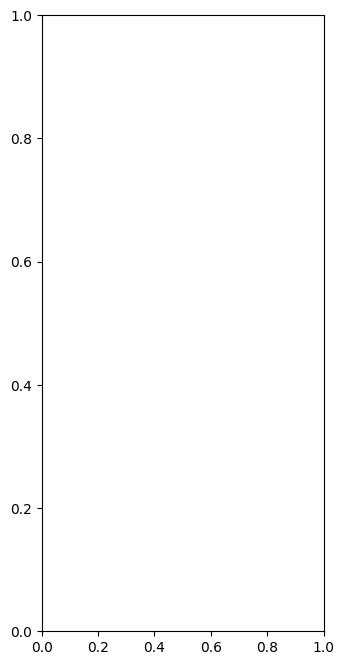

In [32]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
50


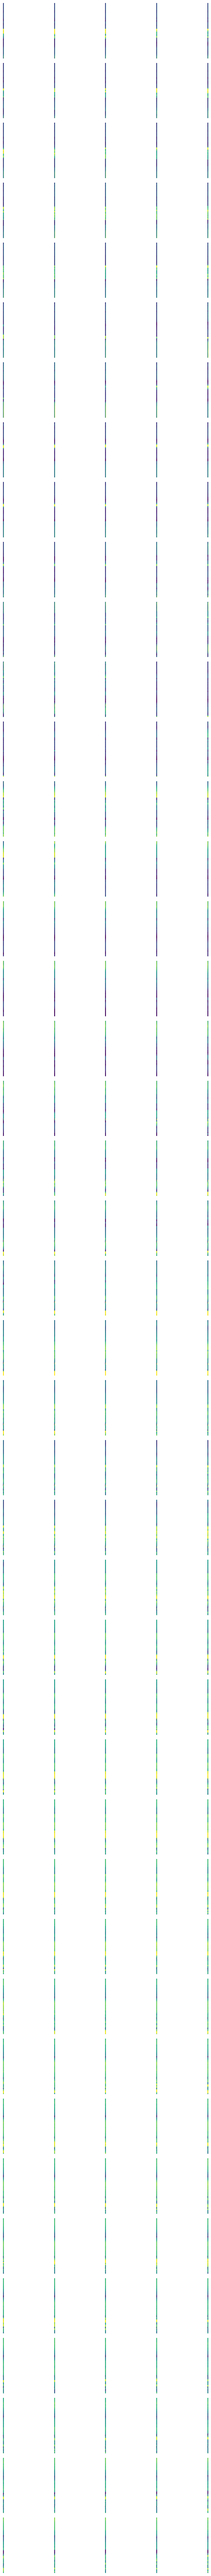

In [33]:
# Assuming the model has already been trained

# Obtain the model's predictions for the test data
predictions = model.predict(test_data_gen, steps=total_test // batch_size, verbose=1)

# Flatten the predictions to 1D array, if necessary
probabilities = predictions.flatten()

# Retrieve a batch of test images (and corresponding labels, though labels are not used here)
batch = next(test_data_gen)

# Inspect the structure of the batch
print(len(batch))  # Should print 2 if it's (images, labels)

# Extract images
test_images = batch[0]

# Define the plotting function
def plotImages(images, probabilities, num_cols=5):
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate number of rows needed

    plt.figure(figsize=(num_cols * 2, num_rows * 2))  # Adjust figure size for visibility

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        #plt.title(f'Prob: {probabilities[i] * 100:.2f}%')
        plt.axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Plot the images with their corresponding probabilities
plotImages(test_images, probabilities)

In [34]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 64.0% of the images of cats and dogs.
You passed the challenge!
